In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import smooth, ellipse_aspect_ratio

df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,1.066764,-0.119714,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,1.016800,-0.154298,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,0.896874,-0.276325,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,0.847358,-0.169788,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.898473,0.197470,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.884289,0.308226,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.883521,0.168561,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.873263,0.225002,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [2]:
wdw = 5
sRc, sR = [], []
for eddy in df_eddies.Eddy.unique():
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    sRc.extend(smooth(df_eddy.Rc, df_eddy.Day, window=wdw, num=len(df_eddy)))
    sR.extend(smooth(df_eddy.R, df_eddy.Day, window=wdw, num=len(df_eddy)))
df_eddies['sRc'] = sRc; df_eddies['sR'] = sR

df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()


In [3]:
print(f'No. of Eddies {len(df_eddies.Eddy.unique())}, No. of Eddy-Days {len(df_eddies)}')
print(f'No. of AEs {len(df_AE.Eddy.unique())}, No. of AE-Days {len(df_AE)}')
print(f'No. of CEs {len(df_CE.Eddy.unique())}, No. of CE-Days {len(df_CE)}')


No. of Eddies 2631, No. of Eddy-Days 105238
No. of AEs 1360, No. of AE-Days 56018
No. of CEs 1271, No. of CE-Days 49220


In [4]:
print('Profiles used for tilt')
print(f'No. of Eddy-Days {len(df_eddies)-6*len(df_eddies.Eddy.unique())}')
print(f'No. of AE-Days {len(df_AE)-6*len(df_AE.Eddy.unique())}')
print(f'No. of CE-Days {len(df_CE)-6*len(df_CE.Eddy.unique())}')



Profiles used for tilt
No. of Eddy-Days 89452
No. of AE-Days 47858
No. of CE-Days 41594


In [5]:
print(f'Oldest AE was {df_AE.Age.max()}')
print(f'Oldest CE was {df_CE.Age.max()}')


Oldest AE was 347
Oldest CE was 203


In [6]:
print(f'Largest Rc was {round(df_eddies.sRc.max())}')
print(f'Median Rc was {round(df_eddies.sRc.median())}')
print(f'Largest AE Rc was {round(df_AE.sRc.max())}')
print(f'Median AE Rc was {round(df_AE.sRc.median())}')
print(f'Largest CE Rc was {round(df_CE.sRc.max())}')
print(f'Median CE Rc was {round(df_CE.sRc.median())}')


Largest Rc was 278
Median Rc was 79
Largest AE Rc was 278
Median AE Rc was 79
Largest CE Rc was 239
Median CE Rc was 79


In [7]:
print(f'Largest R was {round(df_eddies.sR.max())}')
print(f'Median R was {round(df_eddies.sR.median())}')
print(f'Largest AE R was {round(df_AE.sR.max())}')
print(f'Median AE R was {round(df_AE.sR.median())}')
print(f'Largest CE R was {round(df_CE.sR.max())}')
print(f'Median CE R was {round(df_CE.sR.median())}')


Largest R was 173
Median R was 48
Largest AE R was 173
Median AE R was 49
Largest CE R was 140
Median CE R was 47


In [8]:
print(f'Median AE A was {df_AE.A.median()}')
print(f'Median CE A was {df_CE.A.median()}')


Median AE A was 0.004104229642120067
Median CE A was -0.003591236928568481


In [9]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
f =  np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


x-bin size: 29.732563560741596
y-bin size: 49.42377476091224
x-bin size: 29.732563560741596
y-bin size: 49.42377476091224


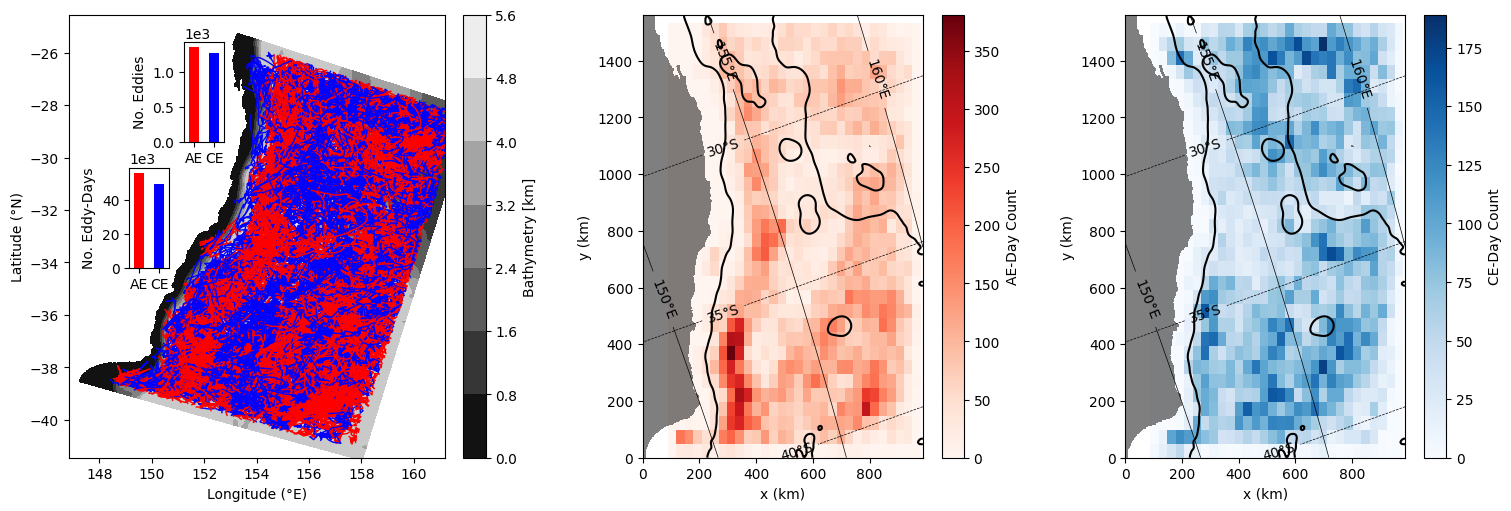

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# --- Panel 1: Map with eddy tracks and insets ---
ax = axs[0]
cs = ax.contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='grey')
fig.colorbar(cs, ax=ax, label='Bathymetry [km]')

for eddy in df_eddies.Eddy.unique():
    d = df_eddies[df_eddies.Eddy == eddy]
    # ax.plot(d.Lon, d.Lat, lw=1, alpha=1)
    cyc = d.iloc[0].Cyc
    ax.plot(d.Lon, d.Lat, color='r' if cyc=='AE' else 'b', lw=1, alpha=1)

ax.axis('equal')
ax.set_xlim(148, 160)
ax.set_ylim(-40, -26)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')

# Inset 1: Eddy counts
df_unique = df_eddies[['Eddy', 'Cyc']].drop_duplicates()
in_ax1 = inset_axes(ax, width=.4, height=1, loc='center',
                   bbox_to_anchor=(152, -27.5, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_unique['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax1)
in_ax1.set_xlabel('')
in_ax1.set_ylabel('No. Eddies')
in_ax1.tick_params(axis='x', rotation=0)
in_ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax1.set_facecolor('none')

# Inset 2: Eddy-day counts
in_ax2 = inset_axes(ax, width=.4, height=1, loc='center',
                   bbox_to_anchor=(149.9, -32.3, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_eddies['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax2)
in_ax2.set_xlabel('')
in_ax2.set_ylabel('No. Eddy-Days')
in_ax2.tick_params(axis='x', rotation=0)
in_ax2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax2.set_facecolor('none')

def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def bin_edges_fd(x, xgrid, rule='fd'): # Freedman-Diaconis (fg) rationale
    n = len(x)
    if n < 2: return np.array([np.min(x), np.max(x)])
    rng = np.ptp(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    # raw width (km)
    if rule.lower() == 'fd':
        h = 2 * (iqr if iqr > 0 else 1.349*std) / (n ** (1/3))
    else:  # 'scott'
        h = 3.5 * std / (n ** (1/3))

    # fallback if degenerate
    if not np.isfinite(h) or h <= 0:
        h = rng / max(10, np.sqrt(n))

    # snap to grid spacing
    base = _grid_step(xgrid)
    h = _nice_step(h, base)

    lo = np.floor(np.min(x) / h) * h
    hi = np.ceil(np.max(x) / h) * h
    return np.arange(lo, hi + h, h)

# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_eddies[df_eddies.Cyc == 'AE'], df_eddies[df_eddies.Cyc == 'CE']]):
    eddy_x = subset.xc.to_numpy()
    eddy_y = subset.yc.to_numpy()

    x_edges = bin_edges_fd(eddy_x, X_grid, rule='fd')  # or rule='scott'/'fd'
    y_edges = bin_edges_fd(eddy_y, Y_grid, rule='fd')
    print(f'x-bin size: {np.mean(np.diff(x_edges))}')
    print(f'y-bin size: {np.mean(np.diff(y_edges))}')

    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])

    pcm = axs[d+1].pcolormesh(x_edges, y_edges, H, cmap='Reds' if d==0 else 'Blues')
    fig.colorbar(pcm, ax=axs[d+1], label='AE-Day Count' if d==0 else 'CE-Day Count')

    axs[d+1].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d+1].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25], colors='k', linewidths=.5)
    axs[d+1].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d+1].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160], colors='k', linewidths=.5)
    axs[d+1].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    axs[d+1].set_xlabel('x (km)')
    axs[d+1].set_ylabel('y (km)')
    axs[d+1].set_aspect('equal')
    axs[d+1].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


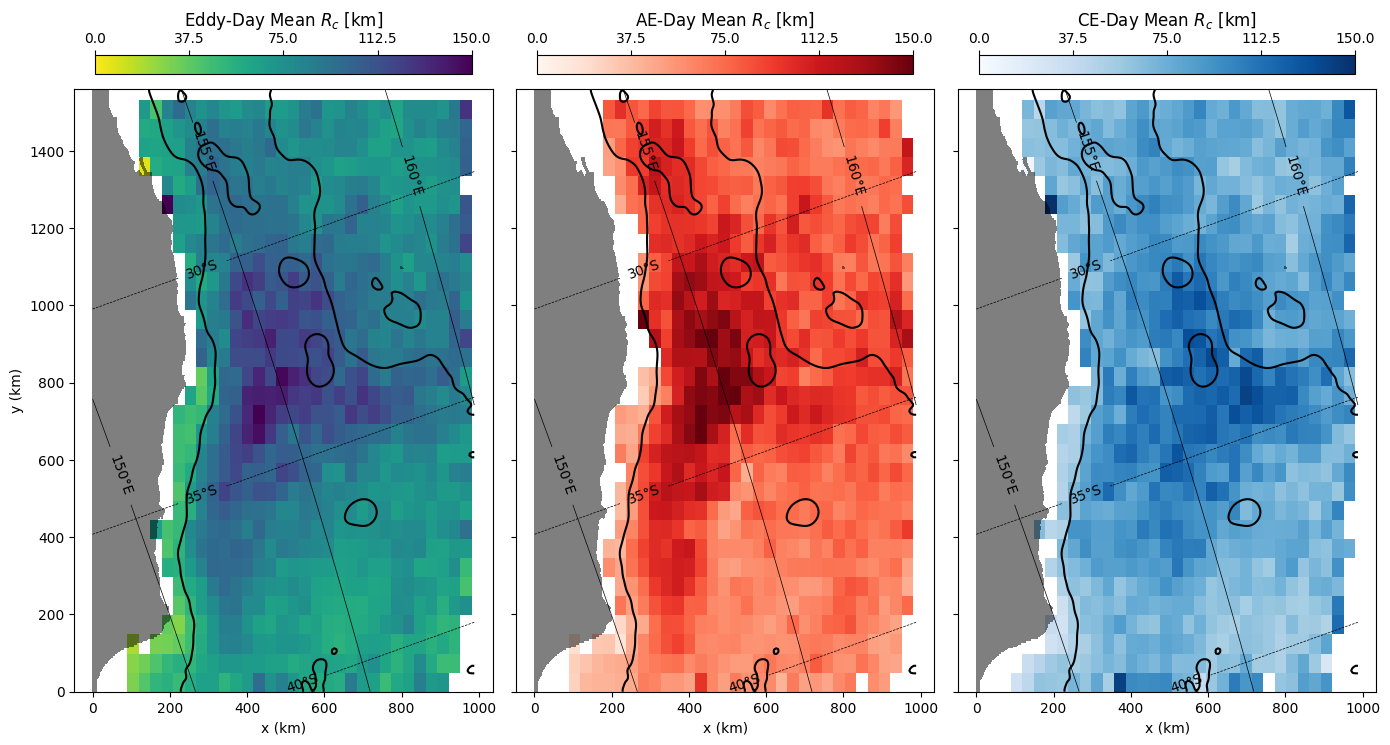

In [11]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)
    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))
    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))
    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)
    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

# compute shared edges once for all panels
xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 150
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"Eddy-Day": "viridis_r", "AE-Day": "Reds", "CE-Day": "Blues"}

def binned_mean(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(v)
    flat = iy[ok]*nx + ix[ok]
    s = np.bincount(flat, weights=v[ok], minlength=nx*ny)
    c = np.bincount(flat, minlength=nx*ny)
    hmean = np.full(nx*ny, np.nan)
    hmean[c>0] = s[c>0]/c[c>0]
    return hmean.reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['Eddy-Day', 'AE-Day', 'CE-Day']):
    ax = axs[p]
    df = df_eddies if cyc == 'Eddy-Day' else df_eddies[df_eddies.Cyc == cyc[:2]]
    df = df.sort_values('Rc', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_mean(df.xc.values, df.yc.values, df.Rc.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm, shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(fr'{cyc} Mean $R_c$ [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 5))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


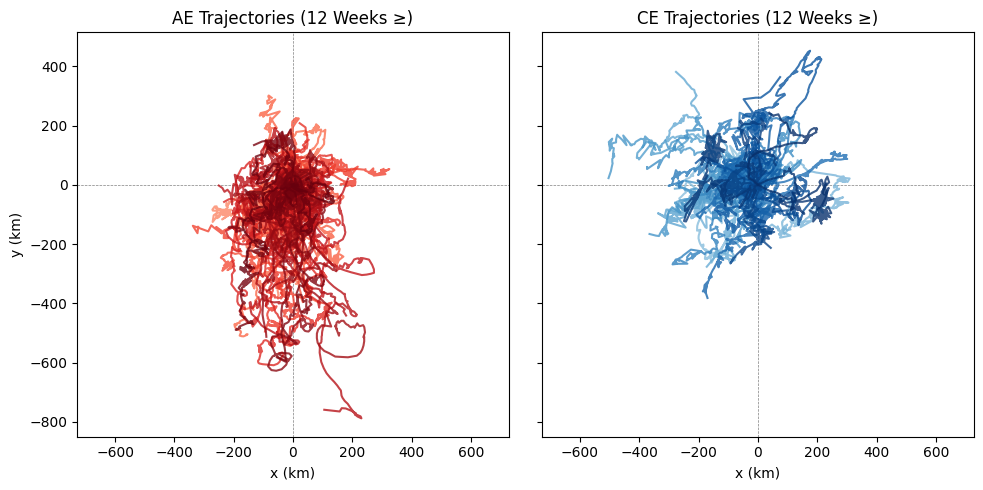

In [12]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
for ax in axs:
    ax.axhline(y=0, color='k', ls='--', alpha=.5, lw=.5)
    ax.axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
# separate groups
ae = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc == 'AE' and df_eddies[df_eddies.Eddy==e].iloc[0].Age >= 12*7]
ce = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc != 'AE' and df_eddies[df_eddies.Eddy==e].iloc[0].Age >= 12*7]

# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

for c, eddy in zip(colors_ae, ae):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc, color=c, alpha=0.8)

for c, eddy in zip(colors_ce, ce):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[1].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc, color=c, alpha=0.8)

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_title('AE Trajectories (12 Weeks ≥)')
axs[1].set_title('CE Trajectories (12 Weeks ≥)')
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[1].set_xlabel('x (km)'); #axs[1].set_ylabel('y (km)')
axs[0].set_xlim(-600, 600); axs[1].set_xlim(-600, 600)

plt.tight_layout()
plt.show()


In [13]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    

In [14]:
depths = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    df = dic_eddies_vert[f'Eddy{data.Eddy}'][f'Day{data.Day}']
    if len(df):
        depths.append(-df.iloc[-1].Depth/1000)
    else:
        depths.append(0)
df_eddies['zmax'] = depths
zmax_idx = [np.argmin(np.abs(-z_r/1000 - z)) for z in df_eddies.zmax]
df_eddies['zmax_idx'] = zmax_idx


In [15]:
ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
df_eddies['EddyProp'] = eddy_props


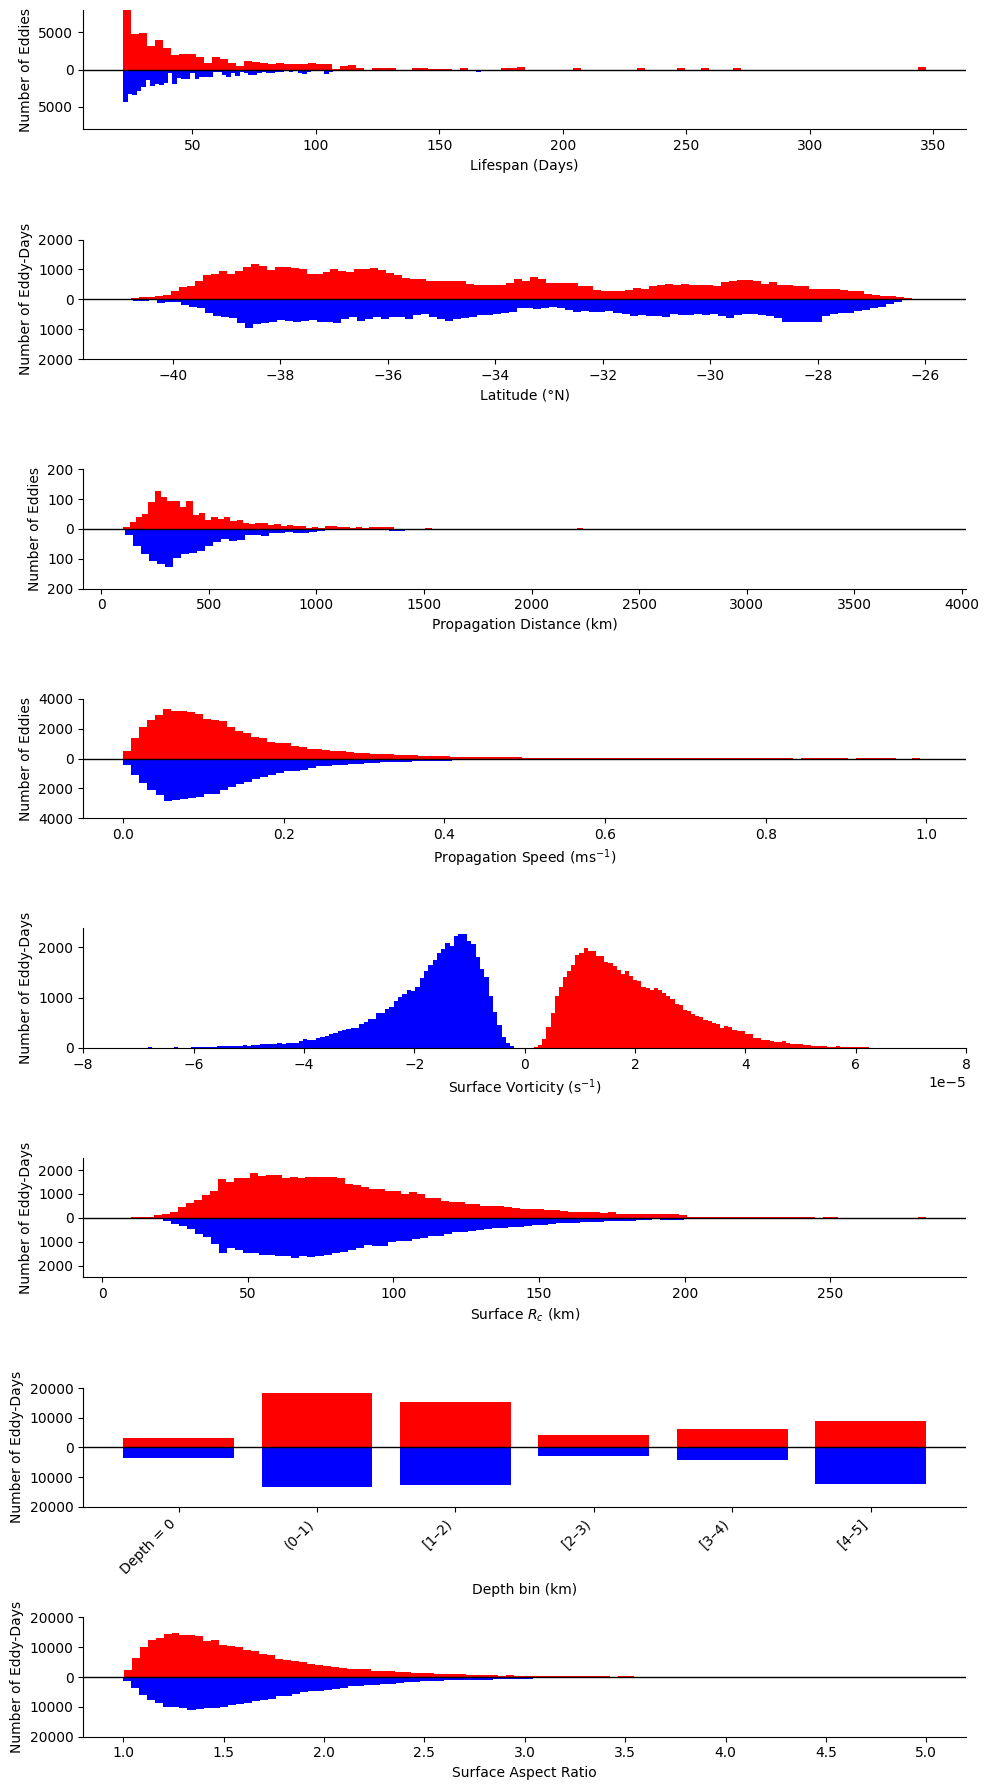

In [18]:
fig, axs = plt.subplots(8, 1, figsize=(10, 18))

# --- Plot 0: Age ---
ax = axs[0]
ages_ae = df_eddies[df_eddies.Cyc == 'AE'].Age
ages_ce = df_eddies[df_eddies.Cyc == 'CE'].Age
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Lifespan (Days)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-8000, 8000)

# --- Plot 1: Lat ---
ax = axs[1]
ages_ae = df_eddies[df_eddies.Cyc == 'AE'].Lat
ages_ce = df_eddies[df_eddies.Cyc == 'CE'].Lat
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-1500, 1500)
ax.set_yticks(axs[1].get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])


# --- Plot 2: Propagation Distance ---
ax = axs[2]
eddy_props_AE, eddy_props_CE = [], []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    dist = np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
    (eddy_props_AE if df.iloc[0].Cyc=='AE' else eddy_props_CE).append(dist)
    # eddy_props.append(dist)
# df_eddies['EddyProp'] = eddy_props
ax.hist(eddy_props_AE, bins=100, color='r')
counts, bins = np.histogram(eddy_props_CE, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ylims = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Propagation Distance (km)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])

# --- Plot 3: Propogations Speed ---
ax = axs[3]
dfAE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
dfAE = dfAE[dfAE.EddyProp <= 1]
dfCE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
dfCE = dfCE[dfCE.EddyProp <= 1]
ax.hist(dfAE.EddyProp, bins=100, color='r')
counts, bins = np.histogram(dfCE.EddyProp, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ylims = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Propagation Speed (ms$^{-1}$)')
ax.set_ylabel('Number of Eddies')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])

# --- Plot 4: Vorticity ---
ax = axs[4]
df_v = df_eddies[df_eddies.w.abs() <= 8e-5]
ax.hist(df_v[df_v.Cyc=='AE'].w, bins=100, color='r')
ax.hist(df_v[df_v.Cyc=='CE'].w, bins=100, color='b')
ax.set_xlim(-8e-5, 8e-5)
ax.set_xlabel(r'Surface Vorticity (s$^{-1}$)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Plot 5: Radius ---
ax = axs[5]
ax.hist(df_eddies[df_eddies.Cyc=='AE'].Rc, bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc=='CE'].Rc, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Surface $R_c$ (km)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-2500, 2500)

# --- Plot 6: Depth ---
# Params
bin_int = 1      # km
max_depth_km = 5 # km
# Edges & labels
edges = np.arange(0, max_depth_km + bin_int, bin_int)
def _fmt(x):
    return f"{x:.0f}" if float(bin_int).is_integer() else f"{x:.1f}"
# Labels: Depth=0 | (0–1) | [1–2) ... [4–5]
bin_labels = (["Depth = 0",
               f"({_fmt(edges[0])}–{_fmt(edges[0] + bin_int)})"]
              + [f"[{_fmt(b)}–{_fmt(b+bin_int)})" for b in edges[1:-1]])
bin_labels[-1] = f"[{_fmt(edges[-2])}–{_fmt(edges[-1])}]"
# Select AE/CE depths (raw arrays)
ae_raw = df_eddies.loc[df_eddies.Cyc == 'AE', 'zmax'].dropna().to_numpy()
ce_raw = df_eddies.loc[df_eddies.Cyc == 'CE', 'zmax'].dropna().to_numpy()
# Clip to plotting range
inrange = lambda a: a[(a >= edges[0]) & (a <= edges[-1])]
ae = inrange(ae_raw)
ce = inrange(ce_raw)
# Separate exact zeros so they don't get counted in (0–1)
ae0 = int(np.isclose(ae, 0).sum())
ce0 = int(np.isclose(ce, 0).sum())
ae_nz = ae[~np.isclose(ae, 0)]
ce_nz = ce[~np.isclose(ce, 0)]
# Histogram counts for the regular bins
ae_counts, _ = np.histogram(ae_nz, bins=edges)
ce_counts, _ = np.histogram(ce_nz, bins=edges)
# Prepend zero-depth counts
ae_counts = np.insert(ae_counts, 0, ae0)
ce_counts = np.insert(ce_counts, 0, ce0)
# Plot (categorical positions)
ax = axs[6]
xpos = np.arange(len(bin_labels))
ax.bar(xpos,  ae_counts, label='AE', color='r')
ax.bar(xpos, -ce_counts, label='CE', color='b')
# Cosmetics
ax.axhline(0, color='k', linewidth=1)
m = max(1, int(max(ae_counts.max(), ce_counts.max()) * 1.1))
ax.set_xticks(xpos)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_xlabel('Depth bin (km)')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
ax.set_ylim(-m, m)

# --- Plot 7: Aspect ratio  ---
ax = axs[7]
df_a = df_eddies[df_eddies.AR <= 5]
ax.hist(df_a[df_a.Cyc=='AE'].AR, bins=100, color='r')
counts, bins = np.histogram(df_a[df_a.Cyc=='CE'].AR, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('Surface Aspect Ratio')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in axs[6].get_yticks()])
# axs[6].set_ylim(-2500, 2500)

# --- Plot 8: Scale (psi0) ---
# ax = axs[7]
# df_p = df_eddies[df_eddies.psi0.abs() < 250]
# ax.hist(df_p[df_p.Cyc=='AE'].psi0, bins=100, color='r')
# ax.hist(df_p[df_p.Cyc=='CE'].psi0, bins=100, color='b')
# ax.set_xlim(-250, 250)
# ax.set_xlabel(r'Surface Scale ($\psi_0$)')
# ax.set_ylabel('Number of Eddy-Days')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# df_p = df_eddies[df_eddies.A.abs() < 250]
# ax = axs[7]
# df_p = df_eddies.copy()
# ax.hist(df_p[df_p.Cyc=='AE'].A/1e6, bins=100, color='r')
# ax.hist(df_p[df_p.Cyc=='CE'].A/1e6, bins=100, color='b')
# # ax.set_xlim(-.02, .02)
# ax.set_xlabel(r'Surface $A$ (s$^{-1}$)')
# ax.set_ylabel('Number of Eddy-Days')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # ax.axvline(x=-8e-6)

plt.tight_layout()
plt.show()


In [19]:
1/np.sqrt(2)

np.float64(0.7071067811865475)

In [ ]:
print(np.median(df_a.AR.values))

df_a_AE = df_a[df_a.Cyc=='AE']
df_a_CE = df_a[df_a.Cyc=='CE']

print(np.median(df_a_AE.AR.values))
print(np.median(df_a_CE.AR.values))
